**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime as datetime

**Preprocessing**

In [2]:
from os import listdir

weather_df = pd.read_csv('datasets/weather_hourly_helsinki.csv', header=2)
bike_df = pd.DataFrame(columns=['Departure', 'Return', 'Departure station id', 'Departure station name', 'Return station id', 'Return station name', 'Covered distance (m)', 'Duration (sec.)'])

print('Loading datasets...')
for dataset in listdir('datasets'):
  if dataset == 'weather_hourly_helsinki.csv' or dataset == 'full_bike_data.csv' or dataset.endswith('.gz'):
    continue
  temp_df = pd.read_csv('datasets/' + dataset, low_memory=False)
  bike_df = pd.concat([bike_df, temp_df])

bike_df['Departure'] = pd.to_datetime(bike_df['Departure'], format='mixed')
bike_df['Return'] = pd.to_datetime(bike_df['Return'], format='mixed')
bike_df.to_csv('datasets/full_bike_data.csv')

for station in bike_df['Departure station name'].unique():
  print(f'Aggregating over {station}')
  columns = ['Departure', 'Departure station name', 'Departure station id']
  temp_station = bike_df.loc[bike_df['Departure station name'] == station, columns]
  temp_station['trip'] = 1

  temp_station = temp_station.resample('h', on='Departure').trip.sum()

  print('Writing aggregated dataframe to .csv...')
  try:
    name = station.replace('/', '-')
    temp_station.to_csv('datasets/' + name + '_hourly_aggregate.csv', mode='x')
  except Exception as e:
    print(f'Failed to write {station} due to {e}')

for station in bike_df['Return station name'].unique():
  print(f'Aggregating over {station}')
  columns = ['Return', 'Return station name', 'Return station id']
  temp_station = bike_df.loc[bike_df['Return station name'] == station, columns]
  temp_station['trip'] = 1

  temp_station = temp_station.resample('h', on='Return').trip.sum()

  print('Writing aggregated dataframe to .csv...')
  try:
    name = station.replace('/', '-')
    temp_station.to_csv('datasets/' + name + '_return_hourly_aggregate.csv', mode='x')
  except Exception as e:
    print(f'Failed to write {station} due to {e}')

Aggregating over Sammonpuistikko
Writing aggregated dataframe to .csv...
Aggregating over Albertinkatu
Writing aggregated dataframe to .csv...
Aggregating over Arabiankatu
Writing aggregated dataframe to .csv...
Aggregating over Piispanportti
Writing aggregated dataframe to .csv...
Aggregating over Marian sairaala
Writing aggregated dataframe to .csv...
Aggregating over Perämiehenkatu
Writing aggregated dataframe to .csv...
Aggregating over Töölönlahdenkatu
Writing aggregated dataframe to .csv...
Aggregating over Koskelantie
Writing aggregated dataframe to .csv...
Aggregating over Päijänteentie
Writing aggregated dataframe to .csv...
Aggregating over Lintulahdenkatu
Writing aggregated dataframe to .csv...
Aggregating over Kansallismuseo
Writing aggregated dataframe to .csv...
Aggregating over Laulurastaantie
Writing aggregated dataframe to .csv...
Aggregating over Kaivopuisto
Writing aggregated dataframe to .csv...
Aggregating over Jämeräntaival
Writing aggregated dataframe to .csv...


**Plotting the Distribution of Bike Trips by Year**

/tmp/ipykernel_354687/4263803594.py:1: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datasets/full_bike_data.csv', low_memory=True)
/tmp/ipykernel_354687/4263803594.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bike_trips_per_year['Year'], y=bike_trips_per_year['Number of Trips'], palette='viridis')


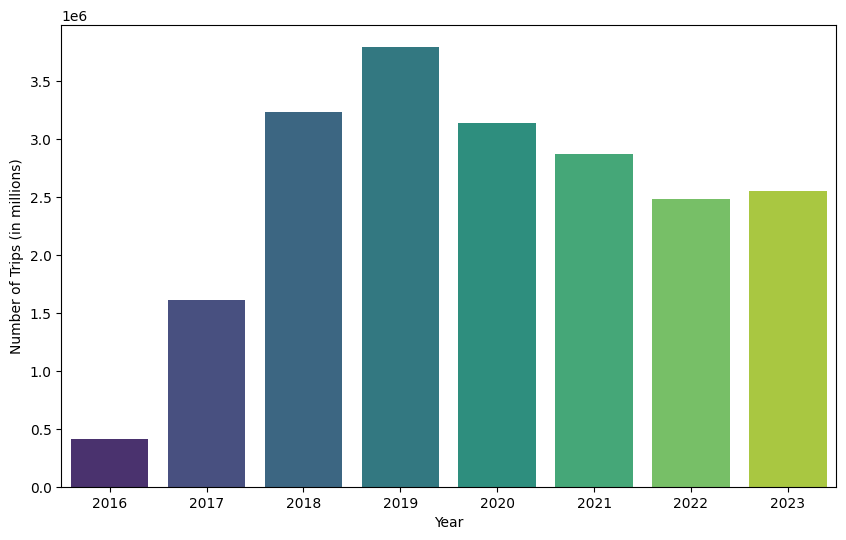

In [2]:
df = pd.read_csv('datasets/full_bike_data.csv', low_memory=True)

df['Departure'] = pd.to_datetime(df['Departure'])
df['Year'] = df['Departure'].dt.year
bike_trips_per_year = df.groupby('Year').size().reset_index(name='Number of Trips')

plt.figure(figsize=(10, 6))
sns.barplot(x=bike_trips_per_year['Year'], y=bike_trips_per_year['Number of Trips'], palette='viridis')

plt.xlabel('Year')
plt.ylabel('Number of Trips (in millions)')

plt.show()

**Model for Predicting Departure Count**

In [6]:
station = 'Kamppi (M)'

data = pd.read_csv('datasets/' + station + '_hourly_aggregate.csv')
data['Departure'] = pd.to_datetime(data['Departure'], format='mixed')

weather_df = pd.read_csv('datasets/weather_hourly_helsinki.csv', header=2)
weather_df['time'] = pd.to_datetime(weather_df['time'], format='mixed')

data = pd.merge(weather_df, data, how='inner', left_on='time', right_on='Departure')
data = data.drop(['time'], axis=1)
data.set_index(data['temperature_2m (°C)'], inplace=True)
data.set_index(data['rain (mm)'], inplace=True)
data.set_index(data['Departure'], inplace=True)

data['temperature_2m (°C)'] = pd.to_numeric(data['temperature_2m (°C)'], errors='coerce')
data['rain (mm)'] = pd.to_numeric(data['rain (mm)'], errors='coerce')
data['trip'] = pd.to_numeric(data['trip'], errors='coerce')

data = data.dropna(axis=1)

mod = sm.tsa.statespace.SARIMAX(data['trip'], order=(1, 1, 1), seasonal_order=(0, 1, 0, 24), freq='h')
res = mod.fit(disp=False)
print(res.forecast('2024-06-15 14:00:00')[-1])

0.08274263164029039


/tmp/ipykernel_3569458/992788154.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(res.forecast('2024-06-15 14:00:00')[-1])


**Model for Predicting Return Count**

In [2]:
station = 'Kamppi (M)'

data = pd.read_csv('datasets/' + station + '_return_hourly_aggregate.csv')
data['Return'] = pd.to_datetime(data['Return'], format='mixed')

weather_df = pd.read_csv('datasets/weather_hourly_helsinki.csv', header=2)
weather_df['time'] = pd.to_datetime(weather_df['time'], format='mixed')

data = pd.merge(weather_df, data, how='inner', left_on='time', right_on='Return')
data = data.drop(['time'], axis=1)
data.set_index(data['temperature_2m (°C)'], inplace=True)
data.set_index(data['rain (mm)'], inplace=True)
data.set_index(data['Return'], inplace=True)

data['temperature_2m (°C)'] = pd.to_numeric(data['temperature_2m (°C)'], errors='coerce')
data['rain (mm)'] = pd.to_numeric(data['rain (mm)'], errors='coerce')
data['trip'] = pd.to_numeric(data['trip'], errors='coerce')

data = data.dropna(axis=1)

mod = sm.tsa.statespace.SARIMAX(data['trip'], order=(1, 1, 1), seasonal_order=(0, 1, 0, 24), freq='h')
res = mod.fit(disp=False)
print(res.forecast('2024-06-15 14:00:00'))

/home/elliot/Projects/data-science-project/backend/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


2023-11-01 00:00:00    0.332839
2023-11-01 01:00:00    0.108983
2023-11-01 02:00:00    1.033872
2023-11-01 03:00:00    0.008670
2023-11-01 04:00:00    0.000214
                         ...   
2024-06-15 10:00:00    0.075210
2024-06-15 11:00:00    1.075206
2024-06-15 12:00:00    2.075204
2024-06-15 13:00:00    0.075204
2024-06-15 14:00:00    0.075204
Freq: h, Name: predicted_mean, Length: 5463, dtype: float64
